In [193]:
#qiskitQIMP\Scripts\activate.bat

import qiskit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as matpltimg

from skimage.transform import resize

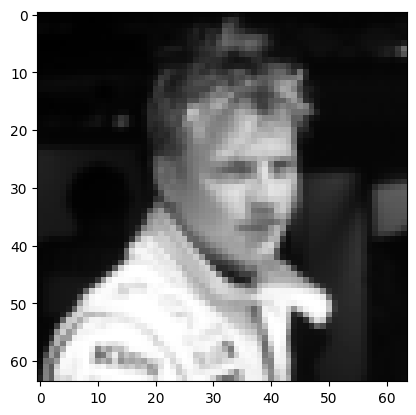

In [194]:
#Import + Processing
filename = 'kimi.jpg'
image = matpltimg.imread(filename)

# Resize the image
n_qubits = 12 # an even number, since image is square
n_pixels_per_side = 2**int(n_qubits/2)
image = resize(image, (n_pixels_per_side, n_pixels_per_side))

image = 0.299*image[:,:,0]+0.586*image[:,:,1]+0.144*image[:,:,2]

fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
plt.show()

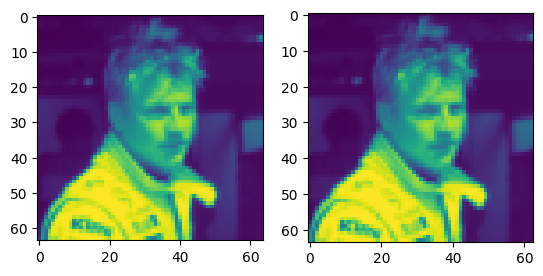

In [195]:
image_trim = image[:, 1:]
rightmost_col = image[:, -1:]

image1 = np.hstack([image_trim, rightmost_col])
fig, ax = plt.subplots(1,2)
# ax.imshow(image1, cmap='gray')
ax[0].imshow(image)
ax[1].imshow(image_trim)

In [196]:
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import Initialize
from qiskit import QuantumCircuit

data0 = image.ravel()
data0 = data0 / np.linalg.norm(data0)

data1 = image1.ravel()
data1 = data1 / np.linalg.norm(data1)

#Initialize gates
init_gate0 = Initialize(data0)
qc0 = QuantumCircuit(n_qubits)
qc0.append(init_gate0, qc0.qubits)
state0 = Statevector.from_instruction(qc0)

init_gate1 = Initialize(data1)
qc1 = QuantumCircuit(n_qubits)
qc1.append(init_gate1, qc1.qubits)
state1 = Statevector.from_instruction(qc1)

#The quantum circuit with one hadamard
qc_h = QuantumCircuit(n_qubits)     
qc_h.h(0)

#Pass states through
new_state0 = state0.evolve(qc_h)
new_state1 = state1.evolve(qc_h)

edge0 = np.real(new_state0)
edge1 = np.real(new_state1)

# Reshape into square image
edge0 = edge0.reshape(n_pixels_per_side, n_pixels_per_side)
edge1 = edge1.reshape(n_pixels_per_side, n_pixels_per_side)


#Put back image1
image_trim = edge1[:, :-1]
leftmost_col = edge1[:, :1]

edge1 = np.hstack([leftmost_col, image_trim])


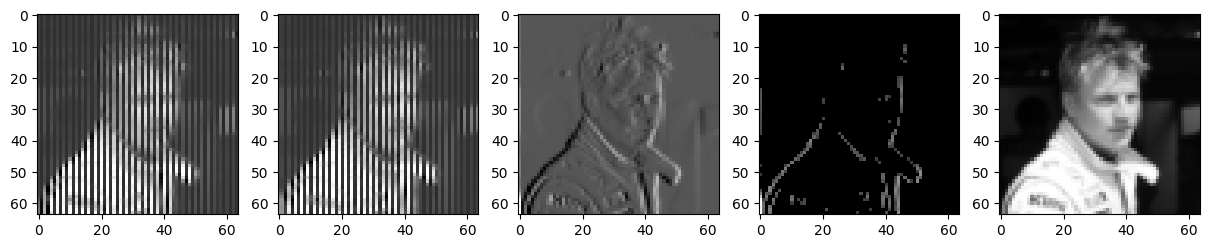

In [197]:

#Interlace the images
interlaced = np.zeros_like(edge0)
for col in range(n_pixels_per_side):
    if col % 2 == 1:
        interlaced[:, col] = edge0[:, col]  # even columns from img1
    else:
        interlaced[:, col] = edge1[:, col]  # odd columns from img2

#Filtero ut small values
abs_img = np.abs(interlaced)
filtered = np.where(abs_img >= 0.005, abs_img, 0)

#Plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 5, figsize=(15,15))
ax[0].imshow(edge0, cmap='gray')
ax[1].imshow(edge1, cmap='gray')
ax[2].imshow(interlaced, cmap='gray')
ax[3].imshow(filtered, cmap='gray')
ax[4].imshow(image, cmap='gray')  # im is the original image
plt.show()